# Assignment 3

### Updating test environment

In [ ]:
#Updating and restarting sklearn
!pip install --upgrade scikit-learn --quiet

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
!pip install --upgrade seaborn==0.11.2

In [ ]:
!pip install xlrd

In [ ]:
# First upgrade the environment.
import pip
from subprocess import run
# add what you will need
modules =[
    'matplotlib', 
    'numpy',
    'pandas',
    'time',
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

## Collecting and importing needed libraries

In [1]:
#Importing needed libraries
import pandas as pd
import numpy as np
from pandas import set_option
import seaborn as sns
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

np.set_printoptions(precision=2)

# Task 1 (7 points):

* Download the data (*sonar.all-data*) from the *Sonar, Mines vs. Rocks Data Set*: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
* Substitute the categories M and R of the last column for integers.
* Find the best parameters on the validation set using gridsearch (min. 2 parameters) for one model.
* Plot a heatmap of the parameters. Find the best set of parameters. Comment your results.
* Plot a ROC curve. Comment your results.

## Reading data and encoding the Label categories

In [2]:
#Reading and loading the data set for Task 1
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
data_1 = pd.read_csv(url, header=None)

In [3]:
#Substituting the categories M and R of the last column for integers
data_1[60] = LabelBinarizer().fit_transform(data_1[60])

## Splitting the data into features/labels, training/validation/test sets 

In [4]:
#Splitting data into features and label
X_data = data_1.iloc[:,0:60]
y_data = data_1[60]

In [5]:
#Splitting data into training+validation and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_data, y_data, random_state=10)

#Splitting train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=10)

print("Size of training set: {} | Size of validation set: {} | Size of test set:" 
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

Size of training set: 117 | Size of validation set: 39 | Size of test set: 52



## Creating Pipeline for scaling and classification

In [6]:
#Creating a function for running the pipeline for scaling and classification
def run_pipeline(sca,mod):
    scaler = sca
    model = mod
    pipe = Pipeline([("scaler", scaler),("model", model)])
    return pipe

## Running baseline model in training and test datasets

In [7]:
#Running the classifier model on the training data using the pipeline
pipe1 = run_pipeline(sca=StandardScaler(),mod=GradientBoostingClassifier(random_state=11))
model_train = pipe1.fit(X_train, y_train)

#Scoring and printing the model using the validation data
val_score = model_train.score(X_valid, y_valid)
print("Validation score: {:.2f}".format(val_score))

Validation score: 0.79


In [8]:
#Building the model on training+validation set using the pipeline
model_trainval = pipe1.fit(X_trainval,y_trainval)

#Scoring the model using the test data
test_score = model_trainval.score(X_test, y_test)
print("Test score: {:.2f}".format(test_score))

Test score: 0.79


## Running gridsearch to find the best parameters

In [9]:
#Setting the parameter grid values
ccp_alpha = [0.0001, 0.001, 0.01, 0.1, 1]
max_features= [5, 10, 20, 40, 60]
param_grid = {'model__ccp_alpha': ccp_alpha,
              'model__max_features': max_features}

In [10]:
#Setting the grid search using the pipeline and parameter grids and fitting grid on the validation data
grid_search = GridSearchCV(pipe1, param_grid)
grid_search.fit(X_valid, y_valid)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        GradientBoostingClassifier(random_state=11))]),
             param_grid={'model__ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                         'model__max_features': [5, 10, 20, 40, 60]})

### Plotting Heatmap of Parameters

<AxesSubplot:xlabel='max_features', ylabel='ccp_alpha'>

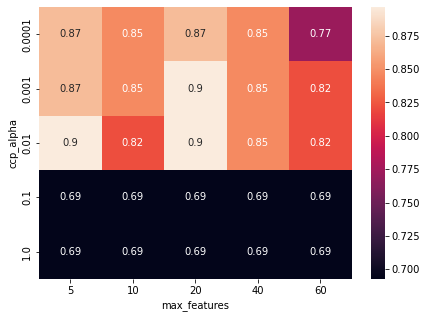

In [11]:
#Preparing the scores for plotting in the heatmap
scores = pd.DataFrame()
scores['test_scores']= grid_search.cv_results_['mean_test_score']
scores['ccp_alpha']= grid_search.cv_results_['param_model__ccp_alpha']
scores['max_features']= grid_search.cv_results_['param_model__max_features']
scores = scores.pivot('ccp_alpha', 'max_features', 'test_scores')

#Plotting the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(scores, annot= True)

Based from the heatmap of accuracy scores plotted with different values of the two parameters, the model performs better at ccp_alpha 0.01 and below and at maximum features equal to 20. The top three combinations are: (ccp_alpha 0.001, max_features = 20), (ccp_alpha 0.01, max_features = 20) and (ccp_alpha 0.01, max_features = 5). These achieved scores of 0.90

We see the scores improved from the baseline model where validation score was 0.79.

### Finding the best set of parameters

In [12]:
#Printing the best parameters
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}\n".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Test set AUC: {:.2f}".format(roc_auc_score(y_test, grid_search.decision_function(X_test))))

Best parameters: {'model__ccp_alpha': 0.001, 'model__max_features': 20}
Best cross-validation score: 0.90

Test set score: 0.62
Test set AUC: 0.72


In [13]:
#Running the classifier model using the best parameters on the training_validation data
pipe2 = run_pipeline(sca=StandardScaler(),
                     mod=GradientBoostingClassifier(ccp_alpha=grid_search.best_params_['model__ccp_alpha'],
                                                    max_features=grid_search.best_params_['model__max_features'], 
                                                    random_state=11))
model_final = pipe2.fit(X_trainval, y_trainval)

#Scoring and printing the model using the validation data
test_score_final = model_final.score(X_test, y_test)
print("Test score: {:.2f}".format(test_score_final))

Test score: 0.81


Based from the gridsearch, the best model is the GradientBoostingClassifier with parameters ccp_alpha = 0.001 and max_features = 20. The best cross-validation score was 0.90, and the test set AUC is 0.72.

Running this model on the train_validation dataset, the test-score is 0.81 which was an improvement from the test score in the baseline model 0.79. This means that even though we used lesser features, we didn't lose accuracy but in fact even improved it.

### Plotting the ROC curve

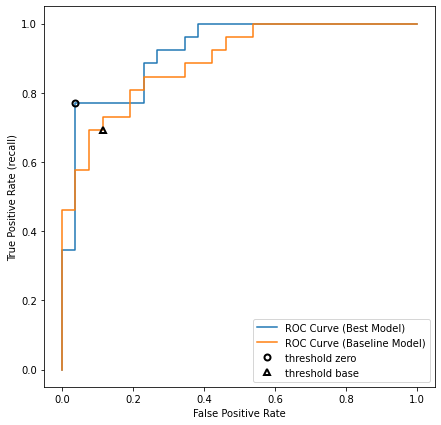

In [14]:
#Plotting the ROC curve
plt.figure(figsize=(7, 7))

fpr, tpr, thresholds = roc_curve(y_test, pipe2.decision_function(X_test))
fpr_base, tpr_base, thresholds_base = roc_curve(y_test, pipe1.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
close_base = np.argmin(np.abs(thresholds_base))

plt.plot(fpr, tpr, label="ROC Curve (Best Model)")
plt.plot(fpr_base, tpr_base, label="ROC Curve (Baseline Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o',
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(fpr_base[close_base], tpr_base[close_base], '^',
label="threshold base", fillstyle="none", c='k', mew=2)


plt.legend(loc=4)

Looking at the Receiver Operating Characteristic curve, we can say that the model can perfrom well in classifying whether the object is metal or a rock - the threshold for the best model suggests that it has sensitivity in correctly classify objects while keeping false positive rate low.

Comparing the ROC curvey of the model with optimized parameter (Best) versus the baseline model show improvement in the performance of the model.

# Task 2 (8 points):

Data Set Information:

2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C. ...) and to a fetal state (N, S, P). Therefore the dataset can be used either for 10-class or 3-class experiments.

* Download the data from the *Cardiotocography Data Set*: https://archive.ics.uci.edu/ml/datasets/Cardiotocography
* Find the best two models by creating a complete pipeline with different parameters and algorithms. One model should predict the *morphologic pattern* and the other the *fetal state*. 
* Comment on the time and preformance metrics used in each model.

## Reading data

In [15]:
#Reading data
url_2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls'
sheet = 'Data'
df = pd.read_excel(url_2, sheet_name=sheet, skiprows=1)

In [16]:
#Cleaning unnecessary rows
df.dropna(axis=1, how='all', inplace=True)
df.drop(index=[2126,2127,2128], inplace=True)
df

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240.0,357.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,9.0,2.0
1,5.0,632.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,132.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
2,177.0,779.0,2.0,0.0,5.0,2.0,0.0,0.0,0.0,133.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
3,411.0,1192.0,2.0,0.0,6.0,2.0,0.0,0.0,0.0,134.0,...,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,533.0,1147.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,132.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,2059.0,2867.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,140.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,2.0
2122,1576.0,2867.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,140.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,2.0
2123,1576.0,2596.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,140.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,2.0
2124,1576.0,3049.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,140.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,2.0


## Splitting the data into features/labels, training/validation/test sets

In [17]:
#Splitting data into features and label
X_data = df.iloc[:,9:30]
y_data_class = df['CLASS']
y_data_nsp = df['NSP']

In [18]:
#Splitting data into training+validation and test for FHR morphologic pattern
X_trainval_c, X_test_c, y_trainval_c, y_test_c = train_test_split(X_data, y_data_class, random_state=10)
#Splitting train+validation set into training and validation sets for FHR morphologic pattern
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(X_trainval_c, y_trainval_c, random_state=10)

In [19]:
#Splitting data into training+validation and test for NSP fetal state class
X_trainval_n, X_test_n, y_trainval_n, y_test_n = train_test_split(X_data, y_data_nsp, random_state=10)
#Splitting train+validation set into training and validation sets for NSP fetal state class
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(X_trainval_n, y_trainval_n, random_state=10)

## Creating the grids for the different parameters and algorithms

In [20]:
#Creating parameter grids for the different parameters and algorithm
param_grid_ctg = [
    {'scaler': [StandardScaler(), None],
     'model': [SVC(max_iter=30000)],
     'model__tol': [0.001, 0.01, 0.1],
     'model__C': [0.001, 0.01, 0.1]},
    {'scaler': [None],
     'model': [RandomForestClassifier(n_estimators=100,random_state=10)],
     'model__ccp_alpha': [0.001, 0.01, 0.1],
     'model__max_features': [5, 10, 15,21]},
    {'scaler': [None],
     'model': [GradientBoostingClassifier(random_state=10)], 
     'model__ccp_alpha': [0.001, 0.01, 0.1],
     'model__max_features': [5, 10, 15,21]}
]

In [21]:
#Setting the grid search using the pipeline and parameter grids
grid_ctg = GridSearchCV(run_pipeline(sca=StandardScaler(),mod=SVC(max_iter=30000)), param_grid_ctg)

In [27]:
#Fitting the grid on data and printing results
def fit_grid(X_train,y_train, X_test, y_test):
    #Recording time
    start = time()
    #Fitting the grid on data 
    grid_ctg.fit(X_train, y_train)
    #Printing the results
    print("The Gridsearch took %.2f seconds for the 3 algorithm with different parameter settings " 
          % ((time() - start)))
    print("Best params:\n{}\n".format(grid_ctg.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_ctg.best_score_))
    print("Test set score: {:.2f}".format(grid_ctg.score(X_test, y_test)))

## Running the grid using the pipeline to classify the FHR Morphologic pattern

In [28]:
#Running the models for FHR morphologic pattern
fit_grid(X_train=X_valid_c, y_train=y_valid_c, X_test=X_test_c, y_test=y_test_c)

The Gridsearch took 69.14 seconds for the 3 algorithm with different parameter settings 
Best params:
{'model': GradientBoostingClassifier(ccp_alpha=0.001, max_features=21, random_state=10), 'model__ccp_alpha': 0.001, 'model__max_features': 21, 'scaler': None}

Best cross-validation score: 0.83
Test set score: 0.81


## Running the grid using the pipeline to classify the NSP fetal state

In [29]:
#Running the model for the NSP fetal state
fit_grid(X_train=X_valid_n, y_train=y_valid_n, X_test=X_test_n, y_test=y_test_n)

The Gridsearch took 29.27 seconds for the 3 algorithm with different parameter settings 
Best params:
{'model': GradientBoostingClassifier(ccp_alpha=0.001, max_features=15, random_state=10), 'model__ccp_alpha': 0.001, 'model__max_features': 15, 'scaler': None}

Best cross-validation score: 0.90
Test set score: 0.94


## Comments on time and Performance metrics

The models classifying the morphologic patterns took a much longer time running than the models (seconds) classifying the fetal state (seconds).

The best model for classifying the morphologic patterns is the GradientBoostingClassifier with parameters: ccp_alpha=0.001 and max_features=21. This resulted in a cross-validation score of 0.83 and a test score of 81.

The best model for classifying the fetal state resulted in the much higher accuracy scores (cross-validation of 0.90 and test score of 0.94). The best model was also GradientBoostingClassifier but with the parameters ccp_alpha=0.001 and max_features=15.